# More about vectors and plotting

## Vectors in Julia
You can manipulate vectors (otherwise known as lists) easily in Julia. Adding, subtracting, and dot product are built in. But cross product is not, but this is contained in the LinearAlgebra package.

In [1]:
using LinearAlgebra
using LaTeXStrings, Measures

The linear algebra package provides several functions relevant to vector mathematics:

    norm(v)   : the length of a vector v
    cross(v,w): the cross product v x w
    dot(v, w) : the dot product v • w
    
Simple examples:

In [2]:
u = [1,1,1]
v = [1,0,0]
w = [0,1,0]

println("v•w = ",dot(v,w))
println("vxw = ",cross(v,w))
println("|u| = ",round(norm(u),digits=4))

v•w = 0
vxw = [0, 0, 1]
|u| = 1.7321


## Plotting in Julia
### Electric field and potential for a finite charged stick
Let's consider a finite charged (charge=q$) line segment of length L situated on the x-axis. 
The geometry is shown below:

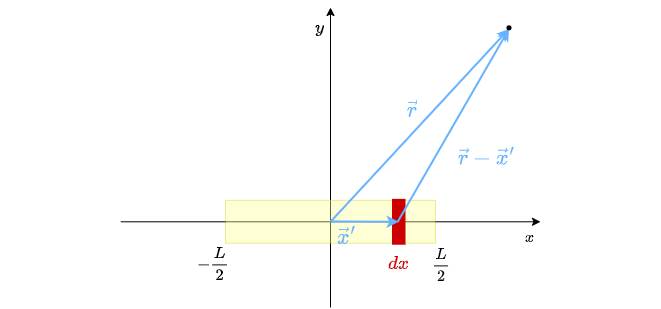



The electric field and potential can be computed using the following:
$$ dE = \frac{1}{4\pi\epsilon_0} \frac{\lambda dx}{(r-x^{\prime})^3} (\vec{r}-\vec{x}^{\prime})$$
and
$$ dE = \frac{1}{4\pi\epsilon_0} \frac{\lambda dx}{(r-x^{\prime})} $$
Note that $\lambda dx = \frac{q}{L} \frac{L}{N} = \frac{q}{N}$, and 
we can now write two functions to compute these two quantities; we'll break up the stick into N chunks and sum the effects from the first chunk (whose center is at $x_1 = -\frac{L}{2} + \frac{\Delta x}{2}$) to the Nth chunk. The $i^{th}$ chunk is at 
$$x_{i} =  -\frac{L}{2} + \frac{(2i-1)}{2}\Delta x,$$ and now we can define functions for the 
electric field and the electric potential:

In [3]:
ϵ₀ = 8.854187817e-12

function E(r, N, q=1.0e-9, L=0.10) 
    E = [0.0, 0.0] # initialize E as a 2d vector
    Δx = L/N       # step size
    for i in range(1,N)
        xᵢ = [-L/2 + 0.5*(2i-1)*Δx, 0.0] # coordinate of i-th chunck of charge
        E = E + (q/N)/(4π*ϵ₀) * (r-xᵢ)./(norm(r-xᵢ)).^3 
    end
    return E
end 

function V(r, N, q=1.0e-9, L=0.10) 
    V = 0
    Δx = L/N
    for i in range(1,N)
        xᵢ = [-L/2 + 0.5*(2i-1)*Δx, 0.0]
        V = V + (q/N)/(4π*ϵ₀)/(norm(r-xᵢ))
    end
    return V
end 

V (generic function with 3 methods)

In [4]:
E([0,1], 100)
V([0,1], 100)

8.983811554490737